In [8]:
import parse
import learning_curve
import numpy as np
import importlib
import ID3

## Question 1
The Node data structure was not conceptually changed, we added attributes in order for us to be able to form the tree.

The attributes Node.attribute, Node.value where added so we could make a decision:

Node.attribute - splitting attribute for nodes

 Node.value - assigned value for leaf nodes. Both were kept whether the node was
a leaf or not in order to maintian one unified structure for the nodes.

Node.is_leaf was added for convenience (Checking len(self.children is also an option)).

## Question 2
We implemented the tree such that it can handle more than two classes , so a case of an "?" is also handled. We got good accuracy results doing that on the house votes dataset, even without pruning.

In [3]:
test_size = 45

data = parse.parse("house_votes_84.data")

#Split to train and test
train = data[:-test_size]
test_ = data[-test_size:]
print(f"Train dataset size : {len(train)}, Test dataset size : {len(test_)}")

#train
tree = ID3.ID3(train, "democrat")

#calculate accuarcy
acc = ID3.test(node = tree, examples=test_)
print(f"The tree has accuracy of : {100.0*acc:.2f}%")

Train dataset size : 390, Test dataset size : 45
The tree has accuracy of : 93.33%


## Question 3

## Question 4

Without pruning:

The training set has 300 examples.


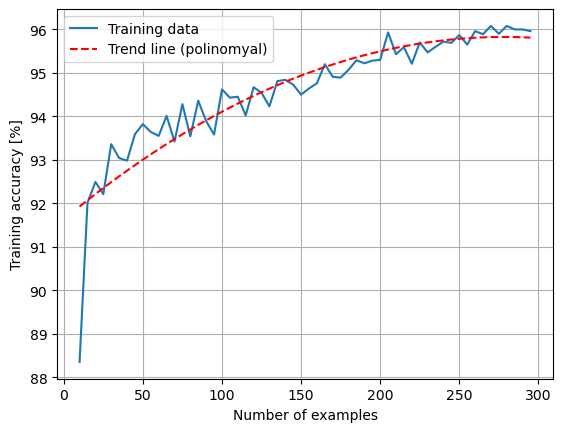

In [36]:
importlib.reload(learning_curve)

train_size = 300
test_size = 100
interations = 100

data = parse.parse("house_votes_84.data")

#Split to train and test and validate
test = data[:test_size]
train = data[test_size:test_size+train_size]
validate = data[:-test_size-train_size]

print(f"The training set has {len(train)} examples.")

example_size = np.arange(10,len(train),5)

learn_curve = np.zeros_like(example_size,dtype='float64')

for it in range(interations):
    learn_curve += learning_curve.get_learning_curve_data(examples_sizes=example_size,train_data=train,test_data=test,default = "democrat")

learn_curve /= interations

learning_curve.plot_learning_curve(example_size,learn_curve)


With pruning:

In [ ]:
importlib.reload(learning_curve)

train_size = 300
test_size = 100
interations = 100

data = parse.parse("house_votes_84.data")

#Split to train and test and validate
test = data[:test_size]
train = data[test_size:test_size+train_size]
validate = data[:-test_size-train_size]

print(f"The training set has {len(train)} examples.")

example_size = np.arange(10,len(train),5)

learn_curve = np.zeros_like(example_size,dtype='float64')

for it in range(interations):
    learn_curve += learning_curve.get_learning_curve_data(examples_sizes=example_size,train_data=train,test_data=test,default = "democrat",prune=True)

learn_curve /= interations

learning_curve.plot_learning_curve(example_size,learn_curve)


### a. 
The general trend is that the accuarcy increases as we provide more examples, in an exponential way. It can observed that in this case the accuracy is nearly 100% given enough examples - in which point overfitting / data memorization is occurring.

### b.

## Question 5


Without pruning:

In [42]:
importlib.reload(ID3)

train = parse.parse("cars_train.data")
test  = parse.parse("cars_test.data")
validate = parse.parse("cars_valid.data")

cars_tree = ID3.ID3(train,default = "unacc")
print("Accuracies:")
acc_train = ID3.test(cars_tree,train)*100
acc_test = ID3.test(cars_tree,test)*100
acc_valid = ID3.test(cars_tree,validate)*100
print(f"Train: {acc_train:.2f}% , Test: {acc_test:.2f}% , Validate: {acc_valid:.2f}%")


Accuracies:
Train: 100.00% , Test: 71.88% , Validate: 78.12%


### Explanation:
The accuracy for the train data is 100% - the ID3 tree was trained on this data, and thus is fit to it very well - possibly too well, as both the test and validate yeild lower accuracies. This might suggest that the tree is overfit to the training data.Without pruning:

With pruning:

In [ ]:
importlib.reload(ID3)

train = parse.parse("cars_train.data")
test  = parse.parse("cars_test.data")
validate = parse.parse("cars_valid.data")

cars_tree = ID3.ID3(train,default = "unacc", prune = True)
print("Accuracies:")
acc_train = ID3.test(cars_tree,train)*100
acc_test = ID3.test(cars_tree,test)*100
acc_valid = ID3.test(cars_tree,validate)*100
print(f"Train: {acc_train:.2f}% , Test: {acc_test:.2f}% , Validate: {acc_valid:.2f}%")